In [27]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from scipy import stats
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [28]:
# import data
dataset_og = pd.read_excel('Data\Measurements_1.xlsx')
# kopie maken indien we iets van de originele data nodig hebben
dataset = dataset_og.copy()
dataset.head(5)

,Externe ID,Geslacht,Geboortedatum,Oogmetingen/Datum,Oogmetingen/Sfr ver,Oogmetingen/Cyl ver,Oogmetingen/As ver,Oogmetingen/Add,Oogmetingen/Sfr dicht,Oogmetingen/Cyl dicht,Oogmetingen/As dicht,Oogmetingen/Sfr ver.1,Oogmetingen/Cyl ver.1,Oogmetingen/As ver.1,Oogmetingen/Add.1,Oogmetingen/Sfr dicht.1,Oogmetingen/Cyl dicht.1,Oogmetingen/As dicht.1
0,__export__.res_partner_10972_f0a5feb4,Vrouw,1962-07-24 00:00:00,2020-05-18 00:00:00,-1.25,-0.50,145.0,NaN,NaN,-1.0,145.0,-0.75,-1.00,20.0,NaN,NaN,-0.5,20.0
1,NaN,NaN,NaN,2017-12-27 00:00:00,-1.25,-0.50,155.0,0.0,0.0,0.0,0.0,-0.75,-0.50,20.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,2012-02-11 00:00:00,-1.00,-0.50,155.0,0.0,0.0,0.0,0.0,-0.50,-0.50,20.0,0.0,0.0,0.0,0.0
3,__export__.res_partner_7722_2342b746,Man,1982-07-10 00:00:00,2020-05-16 00:00:00,-2.00,-1.50,90.0,NaN,NaN,NaN,NaN,-1.50,-1.50,90.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2008-12-13 00:00:00,-1.25,-0.75,85.0,0.0,0.0,0.0,0.0,-1.25,-0.75,90.0,0.0,0.0,0.0,0.0


In [29]:
# og_column names: ['Externe ID', 'Geslacht', 'Geboortedatum', 'Oogmetingen/Datum', 'Oogmetingen/Sfr ver', 'Oogmetingen/Cyl ver', 'Oogmetingen/As ver', 'Oogmetingen/Add', 'Oogmetingen/Sfr dicht', 'Oogmetingen/Cyl dicht', 'Oogmetingen/As dicht', 'Oogmetingen/Sfr ver.1', 'Oogmetingen/Cyl ver.1', 'Oogmetingen/As ver.1', 'Oogmetingen/Add.1', 'Oogmetingen/Sfr dicht.1', 'Oogmetingen/Cyl dicht.1', 'Oogmetingen/As dicht.1']

# rename columns for easier working
# dont rename ['Externe ID', 'Geboortedatum'] for they will be replaced or yeeted
dataset.columns = ['Externe ID', 'Sex', 'Geboortedatum', 'Measurement_Date', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Add-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 'Cyl-Far-L', 'Axis-Far-L', 'Add-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L']

## Transpositie van oogmetingen voor correcte, uniforme data te verkrijgen
op basis van: https://ophthalmictechnician.org/index.php/courses-2/ophthalmic-assistant-basic-training-course/140-spectacles-skills

In [30]:
#drop alle rijen waar enkel Nan waarden zitten (in subset)
dataset = dataset.dropna(thresh=1,subset=['Sph-Far-R','Cyl-Far-R',
                                          'Axis-Far-R','Add-R',
                                          'Sph-Close-R','Cyl-Close-R',
                                          'Axis-Close-R','Sph-Far-L',
                                          'Cyl-Far-L','Axis-Far-L',
                                          'Add-L','Sph-Close-L',
                                          'Cyl-Close-L','Axis-Close-L'])

In [31]:
#controleren of een add.1 beschikbaar is en een add niet of omgekeerd en die dan aanvullen, als beide niet beschikbaar zijn 0 invoegen
values = {'Add-R': dataset['Add-L']}
dataset = dataset.fillna(value=values)
values = {'Add-L': dataset['Add-R']}
dataset = dataset.fillna(value=values)
values = {'Add-L': 0,
          'Add-R':0}
dataset = dataset.fillna(value=values)

In [32]:
#sfr dicht = sfr ver + add
#sfr ver = sfr dicht - add
values = {'Sph-Close-R': dataset['Sph-Far-R'].add(dataset['Add-R']),
          'Sph-Close-L':dataset['Sph-Far-L'].add(dataset['Add-L']) }
dataset = dataset.fillna(value=values)
values = {'Sph-Far-R': dataset['Sph-Close-R'].add(dataset['Add-R']),
          'Sph-Far-L':dataset['Sph-Close-L'].add(dataset['Add-L']) }
dataset = dataset.fillna(value=values)

In [33]:
#cyl en as dicht  = cyl en as ver en vice versa
values = {'Cyl-Close-R': dataset['Cyl-Far-R'],
          'Axis-Close-R':dataset['Axis-Far-R'],
          'Cyl-Close-L': dataset['Cyl-Far-L'],
          'Axis-Close-L':dataset['Axis-Far-L'] }
dataset = dataset.fillna(value=values)
values = {'Cyl-Far-R': dataset['Cyl-Close-R'],
          'Axis-Far-R':dataset['Axis-Close-R'],
          'Cyl-Far-L': dataset['Cyl-Close-L'],
          'Axis-Far-L':dataset['Axis-Close-L'] }
dataset = dataset.fillna(value=values)

In [34]:
#fill overige NaN waardes met 0
values = {'Sph-Far-R': 0, 'Cyl-Far-R': 0, 'Axis-Far-R':0 ,'Add-R':0,'Sph-Close-R':0,'Cyl-Close-R':0,'Axis-Close-R':0,'Sph-Far-L':0,'Cyl-Far-L':0,'Axis-Far-L':0,'Add-L':0,'Sph-Close-L':0,'Cyl-Close-L':0,'Axis-Close-L':0}
dataset = dataset.fillna(value=values)

In [35]:
dictSphFarR, dictCylFarR, dictAxisFarR, dictSphCloseR, dictCylCloseR, dictAxisCloseR, dictSphFarL, dictCylFarL, dictAxisFarL, dictSphCloseL, dictCylCloseL, dictAxisCloseL = {},{},{},{},{},{},{},{},{},{},{},{}

for index, row in dataset.iterrows():
    if row['Cyl-Far-R']<0:
        SphFarR = row['Sph-Far-R']+row['Cyl-Far-R']
        CylFarR = row['Cyl-Far-R']-2*row['Cyl-Far-R']
        key = index
        dictSphFarR[key] = SphFarR
        dictCylFarR[key] = CylFarR
        if row['Axis-Far-R'] <= 90:
            dictAxisFarR[key] = row['Axis-Far-R']+90
        elif row['Axis-Far-R'] > 90:
            dictAxisFarR[key] = row['Axis-Far-R']-90
    if row['Cyl-Close-R']<0:
        SphCloseR = row['Sph-Close-R']+row['Cyl-Close-R']
        CylCloseR = row['Cyl-Close-R']-2*row['Cyl-Close-R']
        key = index
        dictSphCloseR[key] = SphCloseR
        dictCylCloseR[key] = CylCloseR
        if row['Axis-Close-R'] <= 90:
            dictAxisCloseR[key] = row['Axis-Close-R']+90
        elif row['Axis-Close-R'] > 90:
            dictAxisCloseR[key] = row['Axis-Close-R']-90
    if row['Cyl-Far-L']<0:
        SphFarL = row['Sph-Far-L']+row['Cyl-Far-L']
        CylFarL = row['Cyl-Far-L']-2*row['Cyl-Far-L']
        key = index
        dictSphFarL[key] = SphFarL
        dictCylFarL[key] = CylFarL
        if row['Axis-Far-L'] <= 90:
            dictAxisFarL[key] = row['Axis-Far-L']+90
        elif row['Axis-Far-L'] > 90:
            dictAxisFarL[key] = row['Axis-Far-L']-90
    if row['Cyl-Close-L']<0:
        SphCloseL = row['Sph-Close-L']+row['Cyl-Close-L']
        CylCloseL = row['Cyl-Close-L']-2*row['Cyl-Close-L']
        key = index
        dictSphCloseL[key] = SphCloseL
        dictCylCloseL[key] = CylCloseL
        if row['Axis-Close-L'] <= 90:
            dictAxisCloseL[key] = row['Axis-Close-L']+90
        elif row['Axis-Close-L'] > 90:
            dictAxisCloseL[key] = row['Axis-Close-L']-90

dataset['Sph-Far-R'].update(pd.Series(dictSphFarR))
dataset['Cyl-Far-R'].update(pd.Series(dictCylFarR))
dataset['Axis-Far-R'].update(pd.Series(dictAxisFarR))
dataset['Sph-Close-R'].update(pd.Series(dictSphCloseR))
dataset['Cyl-Close-R'].update(pd.Series(dictCylCloseR))
dataset['Axis-Close-R'].update(pd.Series(dictAxisCloseR))
dataset['Sph-Far-L'].update(pd.Series(dictSphFarL))
dataset['Cyl-Far-L'].update(pd.Series(dictCylFarL))
dataset['Axis-Far-L'].update(pd.Series(dictAxisFarL))
dataset['Sph-Close-L'].update(pd.Series(dictSphCloseL))
dataset['Cyl-Close-L'].update(pd.Series(dictCylCloseL))
dataset['Axis-Close-L'].update(pd.Series(dictAxisCloseL))

## forward fill, Id's aanpassen, leeftijd berekenen, etc.

In [36]:
dataset.shape

(55454, 18)

In [37]:
# forward fill toepassen voor alle records (omdat ze zo gemaakt zijn)
dataset = dataset.fillna(method='ffill')

In [38]:
# ID's omzetten naar 6-cijfer random getal om verbanden tussen patienten te vermeiden
dataset['ID'] = dataset['Externe ID'].astype('category').cat.rename_categories(random.sample(range(100000, 1000000), dataset['Externe ID'].nunique()))
dataset = dataset.drop(columns=['Externe ID'])

In [39]:
# Drop waardes die minder dan 2 records hebben, drops ~10K records, kan mss wat efficienter
for rec in dataset.ID:
    if not len(dataset.loc[dataset['ID'] == rec].index) > 1:
        dataset = dataset[dataset['ID'] != rec]

In [40]:
print(dataset.shape)
dataset.head()

(45314, 18)


,Sex,Geboortedatum,Measurement_Date,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Add-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Add-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L,ID
0,Vrouw,1962-07-24 00:00:00,2020-05-18,-1.75,0.50,55.0,0.0,-2.25,1.0,55.0,-1.75,1.00,110.0,0.0,-1.25,0.5,110.0,573539
1,Vrouw,1962-07-24 00:00:00,2017-12-27,-1.75,0.50,65.0,0.0,0.00,0.0,0.0,-1.25,0.50,110.0,0.0,0.00,0.0,0.0,573539
2,Vrouw,1962-07-24 00:00:00,2012-02-11,-1.50,0.50,65.0,0.0,0.00,0.0,0.0,-1.00,0.50,110.0,0.0,0.00,0.0,0.0,573539
3,Man,1982-07-10 00:00:00,2020-05-16,-3.50,1.50,180.0,0.0,-3.50,1.5,180.0,-3.00,1.50,180.0,0.0,-3.00,1.5,180.0,186690
4,Man,1982-07-10 00:00:00,2008-12-13,-2.00,0.75,175.0,0.0,0.00,0.0,0.0,-2.00,0.75,180.0,0.0,0.00,0.0,0.0,186690


In [41]:
# replace geslacht met int en yeet de 'overige' zijn maar 257 records en kan vreemde verbanden geven
dataset[['Sex']] = dataset[['Sex']].replace({'Vrouw':0, 'Man':1, 'Overige':2, 0:2})
# dataset[['Sex']] = dataset[dataset['Sex'] < 2]

In [42]:
# zet de datums om naar datetime, n/a de out of bounds waarden en versnel het proces door het originele formaat te gebruiken
dataset[['Geboortedatum']] = pd.to_datetime(dataset['Geboortedatum'], errors='coerce', infer_datetime_format=True)
dataset[['Measurement_Date']] = pd.to_datetime(dataset['Measurement_Date'], errors='coerce', infer_datetime_format=True)

# drop de n/a waarden van vorige stap
dataset = dataset.dropna(subset=['Geboortedatum','Measurement_Date'])

In [43]:
# Bereken leeftijd op moment van meting voor makkelijkere correlatie
dataset['Measurement_Age'] = (dataset['Measurement_Date'] - dataset['Geboortedatum']).astype('<m8[Y]')

# drop data van 100+ leeftijd voor model niet te confusen (en natturlijk ook onder 0)
dataset = dataset[(dataset['Measurement_Age'] < 100) & (dataset['Measurement_Age'] > 0)]

In [44]:
# yeet deze kolommen want we hebben ze niet meer nodig
dataset = dataset.drop(columns=['Geboortedatum','Measurement_Date'])
dataset.sort_values(by=['Measurement_Age'], ascending=False).head(5)

,Sex,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Add-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Add-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L,ID,Measurement_Age
25730,1,0.00,0.75,10.0,0.0,0.00,0.75,10.0,0.50,1.25,170.0,0.0,0.50,1.25,170.0,120724,95.0
25731,1,0.00,0.00,0.0,0.0,2.50,1.25,10.0,0.00,0.00,0.0,0.0,4.00,0.75,170.0,120724,95.0
41394,0,5.50,1.00,0.0,0.0,5.50,1.00,0.0,5.00,1.00,0.0,0.0,5.00,1.00,0.0,474092,95.0
53668,1,-1.50,4.00,25.0,0.0,-1.50,4.00,25.0,-0.25,3.25,150.0,0.0,-0.25,3.25,150.0,167239,95.0
55078,1,1.75,0.75,90.0,0.0,1.75,0.75,90.0,3.00,0.00,100.0,0.0,3.00,0.00,100.0,271118,94.0


In [45]:
dataset = dataset.astype('float')

In [46]:
#Verwijderen van de uitschieters
dataset = dataset[(np.abs(stats.zscore(dataset)) < 3).all(axis=1)]

In [47]:
# reorder columns voor leesbaarheid
dataset['Add'] = dataset['Add-R']
dataset = dataset[['ID', 'Sex', 'Measurement_Age', 'Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L']]
dataset.head(10)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,573539.0,0.0,57.0,0.0,-1.75,0.50,55.0,-2.25,1.0,55.0,-1.75,1.00,110.0,-1.25,0.50,110.0
1,573539.0,0.0,55.0,0.0,-1.75,0.50,65.0,0.00,0.0,0.0,-1.25,0.50,110.0,0.00,0.00,0.0
2,573539.0,0.0,49.0,0.0,-1.50,0.50,65.0,0.00,0.0,0.0,-1.00,0.50,110.0,0.00,0.00,0.0
3,186690.0,1.0,37.0,0.0,-3.50,1.50,180.0,-3.50,1.5,180.0,-3.00,1.50,180.0,-3.00,1.50,180.0
4,186690.0,1.0,26.0,0.0,-2.00,0.75,175.0,0.00,0.0,0.0,-2.00,0.75,180.0,0.00,0.00,0.0
5,186690.0,1.0,18.0,0.0,-1.50,0.50,170.0,0.00,0.0,0.0,-1.50,0.50,170.0,0.00,0.00,0.0
6,186690.0,1.0,15.0,0.0,-0.75,0.50,170.0,0.00,0.0,0.0,-1.00,0.50,170.0,0.00,0.00,0.0
9,467701.0,0.0,70.0,3.0,2.25,0.75,90.0,5.25,1.0,90.0,2.75,1.00,95.0,5.75,0.75,95.0
10,467701.0,0.0,61.0,2.5,2.75,0.75,90.0,5.25,2.0,90.0,2.75,2.00,95.0,5.25,0.75,95.0
11,467701.0,0.0,60.0,2.5,2.75,0.75,90.0,5.25,2.0,90.0,2.75,2.00,95.0,5.25,0.75,95.0


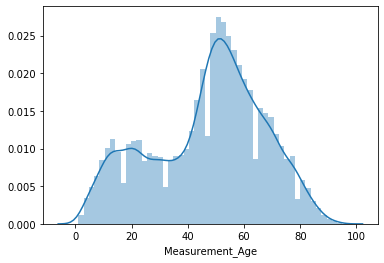

In [48]:
#verdeling leeftijd
ax = sns.distplot(dataset['Measurement_Age'])

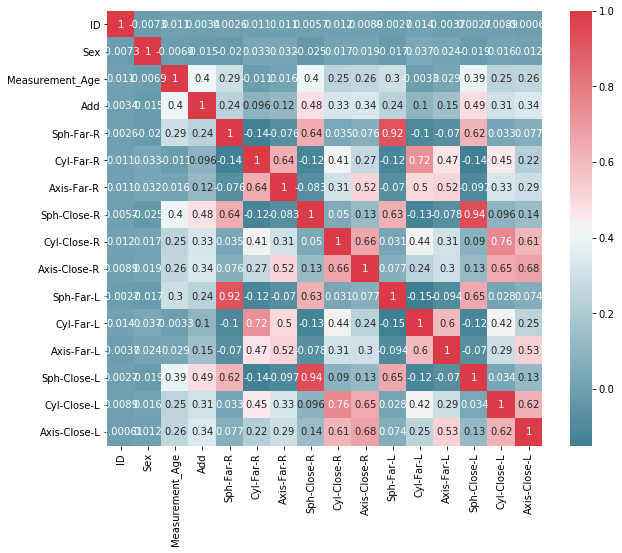

In [49]:
# Visualiseer de onderlinge correlatiecoëfficiënten
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

In [50]:
# niet opnieuw runnen want duurt erg lang
# sns.pairplot(dataset)

In [51]:
dataset.to_csv('Data\Measurements-Transformed', index=False, index_label=False)